# Beta Chain Model Comparisons

## Setup

In [77]:
import os
from pathlib import Path
import sys

if '__project_dir__' not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [78]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn

seaborn.set_theme()
seaborn.set_style('white')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [79]:
BENCHMARKING_PARENT_DIR = Path('benchmarks_beta')

In [80]:
metric_dicts = []

for model in BENCHMARKING_PARENT_DIR.iterdir():
    with open(model/'metrics.json', 'r') as f:
        metric_dicts.append(json.load(f))

## k-NN Scores

In [81]:
knn_scores = {mdict['model_name']: mdict['knn_scores'] for mdict in metric_dicts}
knn_scores = pd.DataFrame.from_dict(knn_scores, orient='index')
knn_scores = knn_scores.sort_values(by='5')
knn_scores.columns = knn_scores.columns.map(lambda x: f'k={x}')

In [82]:
knn_scores

,k=5,k=10,k=50,k=100
BCDR3BERT -pos,0.118621,0.118621,0.110345,0.111379
BCDR3BERT,0.156897,0.161724,0.146207,0.142414
CDR3 Levenshtein,0.172414,0.172759,0.153448,0.143793
BVCDR3BERT,0.189310,0.192759,0.174828,0.159655
CDRBERT,0.203793,0.210690,0.222414,0.206552
BCDRBERT,0.212414,0.217586,0.220690,0.207931
BCDRBERTBDPos,0.213103,0.213103,0.218966,0.214483
BCDRBERT +ACL (cdrcns 0.10),0.238276,0.238276,0.228621,0.217586
BCDRBERT +ACL (cdrcns 0.05),0.239310,0.244483,0.234483,0.222414
BCDRBERT +ACL,0.241379,0.255172,0.228966,0.225862


In [83]:
def knn_plot(models):
    embedding_info = knn_scores.loc[models]
    embedding_info_plot = embedding_info.plot(kind='bar')
    plt.ylabel('knn score')
    plt.xlabel('model name')
    plt.axhline(1/29, color='tab:grey', linestyle='dashed')
    seaborn.move_legend(embedding_info_plot, 'upper left', bbox_to_anchor=(1, 1))
    plt.show()

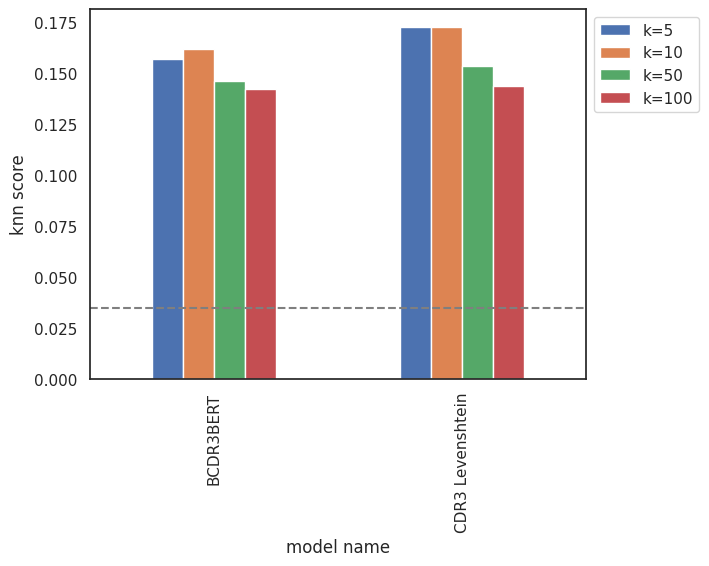

In [84]:
knn_plot(['BCDR3BERT', 'CDR3 Levenshtein'])

### Does it learn better if you add positional info?

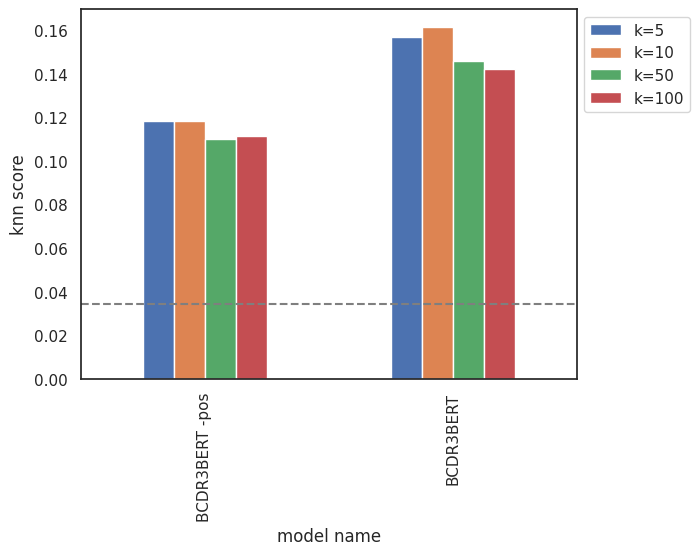

In [85]:
knn_plot(['BCDR3BERT -pos', 'BCDR3BERT'])

### Does it learn better with V gene info?

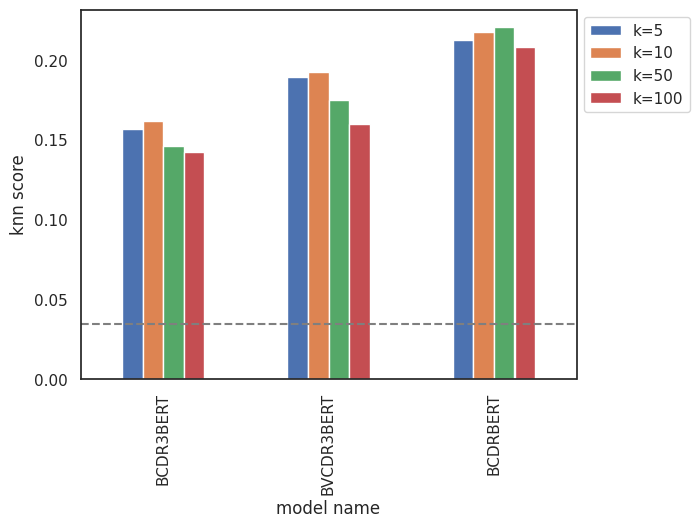

In [86]:
knn_plot(['BCDR3BERT', 'BVCDR3BERT', 'BCDRBERT'])

### Does it learn with autocontrastive learning?

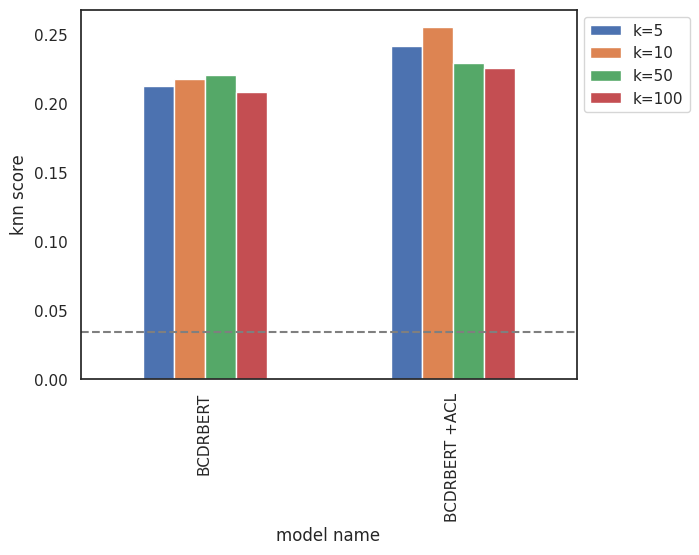

In [87]:
knn_plot(['BCDRBERT', 'BCDRBERT +ACL'])

### Does autocontrastive learning work better with censoring?

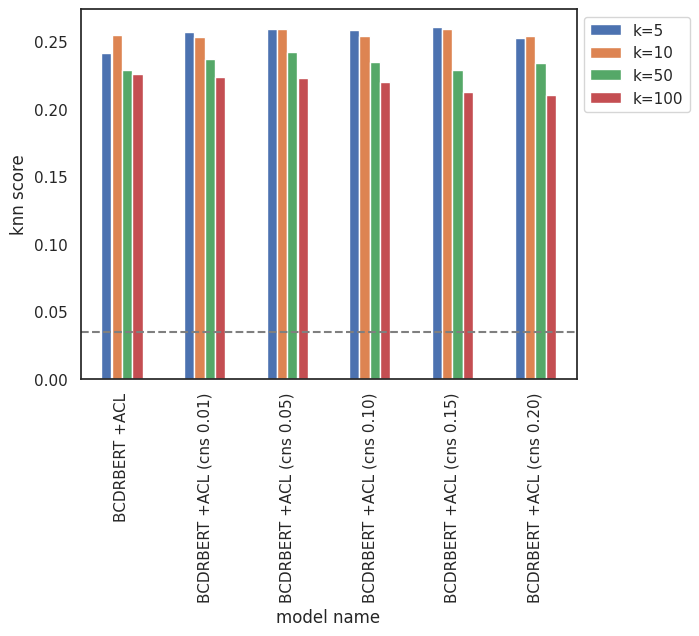

In [88]:
knn_plot(['BCDRBERT +ACL', 'BCDRBERT +ACL (cns 0.01)', 'BCDRBERT +ACL (cns 0.05)', 'BCDRBERT +ACL (cns 0.10)', 'BCDRBERT +ACL (cns 0.15)', 'BCDRBERT +ACL (cns 0.20)'])

In [89]:
# knn_plot(['BCDRBERT +ACL', 'BCDRBERT +ACL (cdrcns 0.01)', 'BCDRBERT +ACL (cdrcns 0.05)', 'BCDRBERT +ACL (cdrcns 0.10)', 'BCDRBERT +ACL (cdrcns 0.15)', 'BCDRBERT +ACL (cdrcns 0.20)'])

### What happens if we train with paired-chain data?

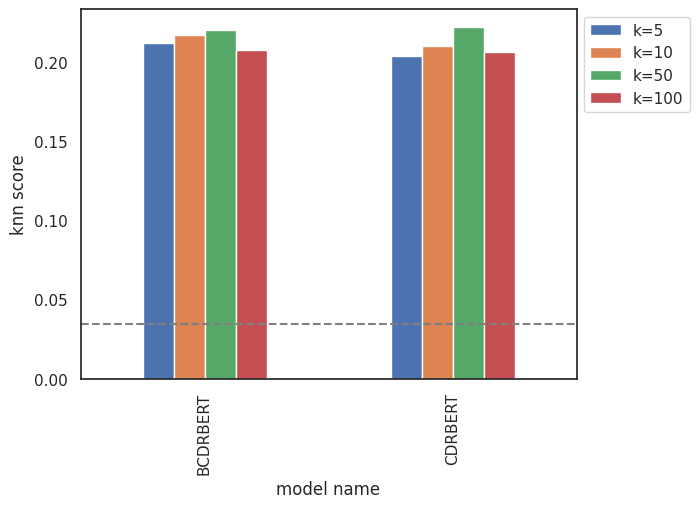

In [90]:
knn_plot(['BCDRBERT', 'CDRBERT'])

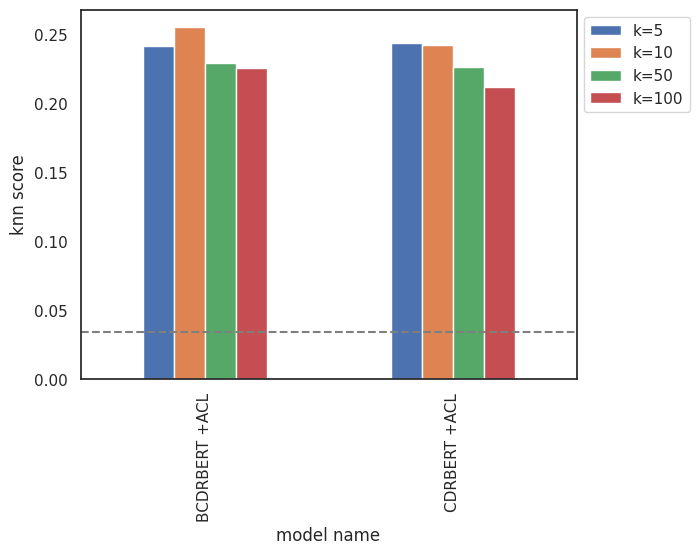

In [91]:
knn_plot(['BCDRBERT +ACL', 'CDRBERT +ACL'])

### Is it better than levenshtein?

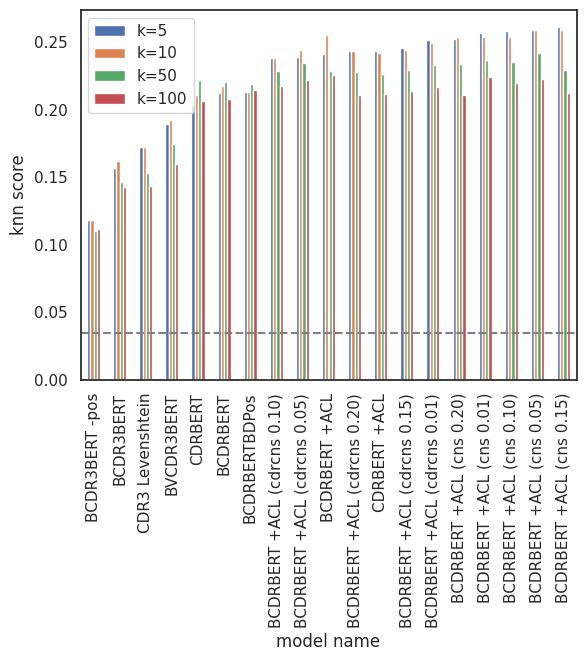

In [92]:
knn_scores.plot(kind='bar')
plt.ylabel('knn score')
plt.xlabel('model name')
plt.axhline(1/29, color='tab:grey', linestyle='dashed')

## Alignment and Uniformity

In [93]:
alnunf = {mdict['model_name']: {'alignment': mdict['alignment'], 'uniformity': mdict['uniformity'], '5nn accuracy': mdict['knn_scores']['5']} for mdict in metric_dicts}
alnunf = pd.DataFrame.from_dict(alnunf, orient='index')
alnunf = alnunf.sort_index()
alnunf['alignment + uniformity'] = alnunf['alignment'] + alnunf['uniformity']
alnunf['-uniformity'] = -alnunf['uniformity']
alnunf = alnunf[alnunf.index != 'CDR3 Levenshtein']

### Alignment + uniformity vs 5-NN performance

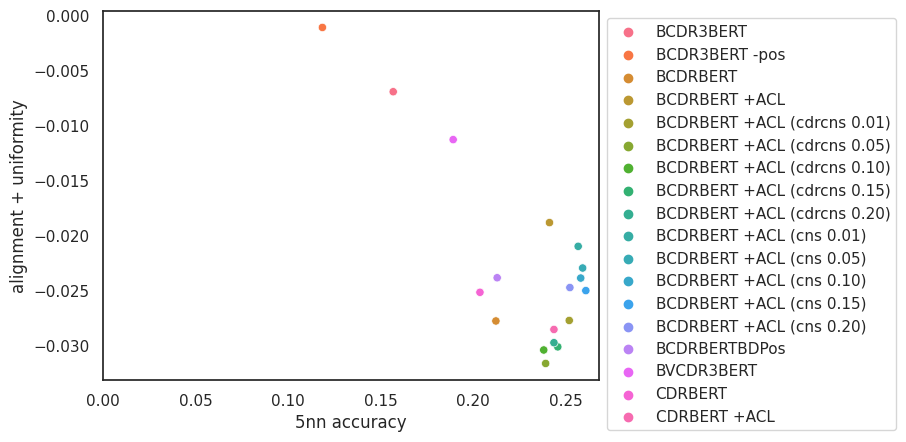

In [94]:
scatter_model_names = seaborn.scatterplot(alnunf, x='5nn accuracy', y='alignment + uniformity', hue=alnunf.index)
scatter_model_names.set_xlim(0)
seaborn.move_legend(scatter_model_names, 'upper left', bbox_to_anchor=(1, 1))
plt.show()

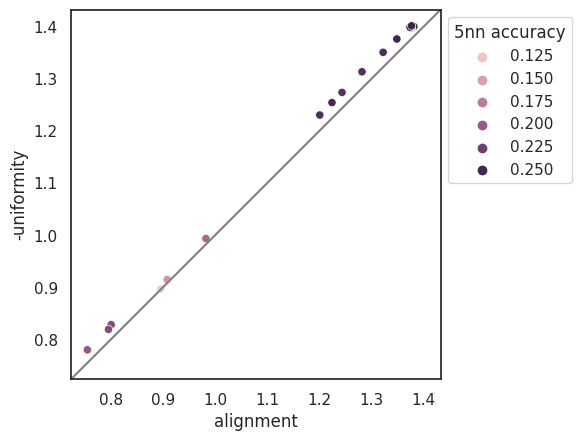

In [95]:
scatter_model_names = seaborn.scatterplot(alnunf, x='alignment', y='-uniformity', hue='5nn accuracy')

lims = [
    min([*scatter_model_names.get_xlim(), *scatter_model_names.get_ylim()]),
    max([*scatter_model_names.get_xlim(), *scatter_model_names.get_ylim()])
]
scatter_model_names.plot(lims, lims, color='grey')
scatter_model_names.set_aspect('equal')
scatter_model_names.set_xlim(lims)
scatter_model_names.set_ylim(lims)

seaborn.move_legend(scatter_model_names, 'upper left', bbox_to_anchor=(1, 1))
plt.show()